In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [1]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cuda


In [3]:
#choppeddata=pd.read_csv('choppeddata_10_06_2021.csv')#.head()
choppeddata1=pd.read_csv('choppeddata_10_04_2021_randomselector_uneven_updatedscaling.csv')#.head()
choppeddata2=pd.read_csv('choppeddata_10_06_2021_randomselector_uneven_updatedscaling.csv')#.head()
choppeddata3=pd.read_csv('choppeddata_10_13_2021_randomselector_uneven.csv')#.head()


print(choppeddata1.shape)
print(choppeddata2.shape)
print(choppeddata3.shape)
frames = [choppeddata1, choppeddata2,choppeddata3]
choppeddata = pd.concat(frames)
print("contatenated data size:")
print(choppeddata.shape)

(16176, 10)
(20880, 10)
(29400, 10)
contatenated data size:
(66456, 10)


In [4]:
print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

(66456, 10)
total runs: 11076


In [5]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)
#print("Train")
#print(train_x[0])
#print(train_y[0])
print("Test set X size", train_x.shape)
print("Train set Y size", train_y.shape)
#print(test_x[0])
#print(test_y[0])
print("Test set X size", test_x.shape)
print("Test set Y size", test_y.shape)

x.shape (11076, 5, 10)
Test set X size (8307, 5, 10)
Train set Y size (8307, 1)
Test set X size (2769, 5, 10)
Test set Y size (2769, 1)


We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [6]:
batch_size = 64
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [7]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model,losslist

def train_existing_model(model,train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    """
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    """    
        
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model,losslist


def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []  #labels
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    #print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    #for i in range(len(outputs)):
    #    sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    #print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets#, sMAPE                               

def evaluatefull_maxdiff(model, train_x, train_y, test_x, test_y,maxdifference=0.2, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    #print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<maxdifference :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<maxdifference :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        else:
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,int(100*test_successcounter/testy.size),"%", "at max difference",maxdifference )
    return ( train_successcounter ,test_successcounter)


def evaluatefull_cutoff(model, train_x, train_y, test_x, test_y,cutoff=0.5, verbose=False):

    #m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    gru_outputs, targets= evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)
    #print("Vs Training Set")
    #print(gru_outputs[0][4])
    train_successcounter=0
    train_failzerocounter=0
    train_failonecounter=0
    for i in range(int(trainy.size)):
        
        if trainy[i]==1  and gru_outputs[0][i]> cutoff:
            train_successcounter+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK" )
        elif trainy[i]==0 and gru_outputs[0][i]<= cutoff :
            train_successcounter+=1
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "OK" )           
        else:
            if verbose==True:
                print(trainy[i],gru_outputs[0][i], "X" )        
           
            if trainy[i]==1:
                train_failonecounter+=1
            if trainy[i]==0:   
                train_failzerocounter+=1
    #print("TRAINING SET: Fails for button not pressed:",  train_failzerocounter,"Fails for button pressed:", train_failonecounter )        
    test_successcounter=0
    test_failzerocounter=0
    test_failonecounter=0
    
    #gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    gru_outputs, targets = evaluate2(gru_model, test_x, test_y)
    #print("Vs Test Set")
    #print(gru_outputs[0][4])
    #print("test size: ",testy.size)

    for i in range(int(testy.size)):
        
        if testy[i]==1 and gru_outputs[0][i]> cutoff :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )
        elif testy[i]==0 and gru_outputs[0][i]<= cutoff   :
            test_successcounter+=1
            if verbose==True:
                print(testy[i],gru_outputs[0][i], "OK" )           
        else:
            #if verbose==True:
            #print(testy[i],gru_outputs[0][i], "X" )
            if testy[i]==1:
                test_failonecounter+=1
            if testy[i]==0:   
                test_failzerocounter+=1
            #print(testy[i])
        #print
        #output = m(input)
    #print("")
    
    print(" vs training data=" ,train_successcounter,"/",trainy.size, " vs test data=" ,
          test_successcounter,"/",testy.size,round((100*test_successcounter/testy.size),2),"%", "at cutoff",cutoff )
    print("TEST SET: Fails for button not pressed:",  test_failzerocounter,"Fails for button pressed:", test_failonecounter , "Total Fails:",test_failzerocounter+test_failonecounter)
    print("")
    return ( train_successcounter ,test_successcounter)


x.shape (11076, 5, 10)
Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/600 Done, Total Loss: 0.04097992661156396   Time Elapsed: 0.2853629999999896 seconds
Epoch 80/600 Done, Total Loss: 0.037859071508165476   Time Elapsed: 0.28465599999999824 seconds
Epoch 120/600 Done, Total Loss: 0.032795175485847185   Time Elapsed: 0.28118700000000274 seconds
Epoch 160/600 Done, Total Loss: 0.030874179066122734   Time Elapsed: 0.2867219999999975 seconds
Epoch 200/600 Done, Total Loss: 0.02853730796699145   Time Elapsed: 0.2785350000000051 seconds
Epoch 240/600 Done, Total Loss: 0.028094172999335004   Time Elapsed: 0.30070600000000525 seconds
Epoch 280/600 Done, Total Loss: 0.02426215563539791   Time Elapsed: 0.2776920000000018 seconds
Epoch 320/600 Done, Total Loss: 0.022130134699562955   Time Elapsed: 0.28314000000000306 seconds
Epoch 360/600 Done, Total Loss: 0.01980414898170866   Time Elapsed: 0.2972660000000076 seconds
Epoch 400/600 Done, Total Loss: 0.0168510233196466   Time Elapsed: 0.3051189999999906 seconds
Epoch 440/600 Done, Total Loss: 0.0160113008

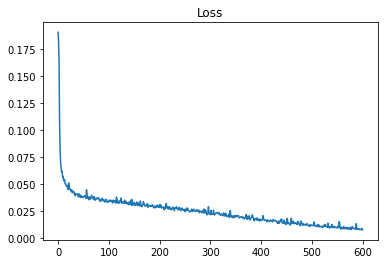

 vs training data= 8290 / 8307  vs test data= 2648 / 2769 95.63 % at cutoff 0.4
TEST SET: Fails for button not pressed: 59 Fails for button pressed: 62 Total Fails: 121

 vs training data= 8285 / 8307  vs test data= 2657 / 2769 95.96 % at cutoff 0.5
TEST SET: Fails for button not pressed: 45 Fails for button pressed: 67 Total Fails: 112



/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:184: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


 vs training data= 8267 / 8307  vs test data= 2656 / 2769 95.92 % at cutoff 0.6
TEST SET: Fails for button not pressed: 30 Fails for button pressed: 83 Total Fails: 113

 vs training data= 8251 / 8307  vs test data= 2649 / 2769 95.67 % at cutoff 0.7
TEST SET: Fails for button not pressed: 26 Fails for button pressed: 94 Total Fails: 120

Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/200 Done, Total Loss: 0.007881440251141555   Time Elapsed: 0.28050199999998426 seconds
Epoch 80/200 Done, Total Loss: 0.007259327523020464   Time Elapsed: 0.2899900000000173 seconds
Epoch 120/200 Done, Total Loss: 0.005568000828204749   Time Elapsed: 0.2851990000000342 seconds
Epoch 160/200 Done, Total Loss: 0.0066020530558285094   Time Elapsed: 0.2819020000000023 seconds
Epoch 200/200 Done, Total Loss: 0.005006307805527377   Time Elapsed: 0.29470900000001166 seconds
Total Training Time: 57.62235299999952 seconds


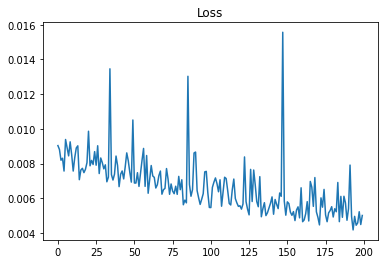

 vs training data= 8302 / 8307  vs test data= 2652 / 2769 95.77 % at cutoff 0.4
TEST SET: Fails for button not pressed: 57 Fails for button pressed: 60 Total Fails: 117

 vs training data= 8301 / 8307  vs test data= 2653 / 2769 95.81 % at cutoff 0.5
TEST SET: Fails for button not pressed: 47 Fails for button pressed: 69 Total Fails: 116

 vs training data= 8296 / 8307  vs test data= 2651 / 2769 95.74 % at cutoff 0.6
TEST SET: Fails for button not pressed: 38 Fails for button pressed: 80 Total Fails: 118

 vs training data= 8288 / 8307  vs test data= 2647 / 2769 95.59 % at cutoff 0.7
TEST SET: Fails for button not pressed: 31 Fails for button pressed: 91 Total Fails: 122

Starting Training of GRU model
Epoch 40/200 Done, Total Loss: 0.004148332791063617   Time Elapsed: 0.2978459999999927 seconds
Epoch 80/200 Done, Total Loss: 0.0069195412951268895   Time Elapsed: 0.2856830000000059 seconds
Epoch 120/200 Done, Total Loss: 0.0036197717485646178   Time Elapsed: 0.28019199999999955 seconds


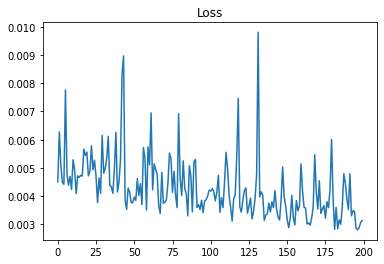

 vs training data= 8304 / 8307  vs test data= 2645 / 2769 95.52 % at cutoff 0.4
TEST SET: Fails for button not pressed: 74 Fails for button pressed: 50 Total Fails: 124

 vs training data= 8304 / 8307  vs test data= 2651 / 2769 95.74 % at cutoff 0.5
TEST SET: Fails for button not pressed: 57 Fails for button pressed: 61 Total Fails: 118

 vs training data= 8304 / 8307  vs test data= 2655 / 2769 95.88 % at cutoff 0.6
TEST SET: Fails for button not pressed: 44 Fails for button pressed: 70 Total Fails: 114

 vs training data= 8299 / 8307  vs test data= 2658 / 2769 95.99 % at cutoff 0.7
TEST SET: Fails for button not pressed: 27 Fails for button pressed: 84 Total Fails: 111

Starting Training of GRU model
Epoch 40/200 Done, Total Loss: 0.0031487771649231283   Time Elapsed: 0.28875499999998056 seconds
Epoch 80/200 Done, Total Loss: 0.0031982059328809613   Time Elapsed: 0.28551200000003973 seconds
Epoch 120/200 Done, Total Loss: 0.002911709129896968   Time Elapsed: 0.29352800000003754 second

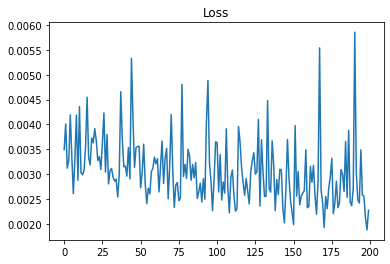

 vs training data= 8306 / 8307  vs test data= 2648 / 2769 95.63 % at cutoff 0.4
TEST SET: Fails for button not pressed: 63 Fails for button pressed: 58 Total Fails: 121

 vs training data= 8306 / 8307  vs test data= 2659 / 2769 96.03 % at cutoff 0.5
TEST SET: Fails for button not pressed: 43 Fails for button pressed: 67 Total Fails: 110

 vs training data= 8306 / 8307  vs test data= 2662 / 2769 96.14 % at cutoff 0.6
TEST SET: Fails for button not pressed: 35 Fails for button pressed: 72 Total Fails: 107

 vs training data= 8305 / 8307  vs test data= 2647 / 2769 95.59 % at cutoff 0.7
TEST SET: Fails for button not pressed: 28 Fails for button pressed: 94 Total Fails: 122

Starting Training of GRU model
Epoch 40/200 Done, Total Loss: 0.0019672609380150374   Time Elapsed: 0.27513000000004695 seconds
Epoch 80/200 Done, Total Loss: 0.0020374732259877547   Time Elapsed: 0.2772690000000466 seconds
Epoch 120/200 Done, Total Loss: 0.003637921175190298   Time Elapsed: 0.29050600000005034 seconds

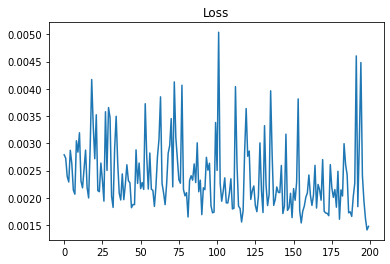

 vs training data= 8306 / 8307  vs test data= 2659 / 2769 96.03 % at cutoff 0.4
TEST SET: Fails for button not pressed: 49 Fails for button pressed: 61 Total Fails: 110

 vs training data= 8306 / 8307  vs test data= 2662 / 2769 96.14 % at cutoff 0.5
TEST SET: Fails for button not pressed: 41 Fails for button pressed: 66 Total Fails: 107

 vs training data= 8306 / 8307  vs test data= 2651 / 2769 95.74 % at cutoff 0.6
TEST SET: Fails for button not pressed: 38 Fails for button pressed: 80 Total Fails: 118

 vs training data= 8305 / 8307  vs test data= 2649 / 2769 95.67 % at cutoff 0.7
TEST SET: Fails for button not pressed: 28 Fails for button pressed: 92 Total Fails: 120

Starting Training of GRU model
Epoch 40/200 Done, Total Loss: 0.0021599159267362816   Time Elapsed: 0.2856219999999894 seconds
Epoch 80/200 Done, Total Loss: 0.004723386901300834   Time Elapsed: 0.28562399999998433 seconds
Epoch 120/200 Done, Total Loss: 0.0017354412666745773   Time Elapsed: 0.30110899999999674 seconds

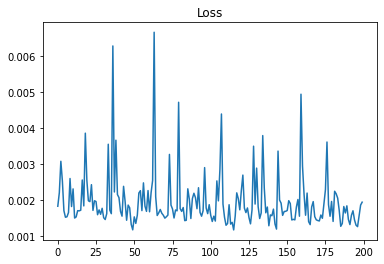

 vs training data= 8306 / 8307  vs test data= 2651 / 2769 95.74 % at cutoff 0.4
TEST SET: Fails for button not pressed: 48 Fails for button pressed: 70 Total Fails: 118

 vs training data= 8306 / 8307  vs test data= 2655 / 2769 95.88 % at cutoff 0.5
TEST SET: Fails for button not pressed: 39 Fails for button pressed: 75 Total Fails: 114

 vs training data= 8306 / 8307  vs test data= 2650 / 2769 95.7 % at cutoff 0.6
TEST SET: Fails for button not pressed: 30 Fails for button pressed: 89 Total Fails: 119

 vs training data= 8306 / 8307  vs test data= 2641 / 2769 95.38 % at cutoff 0.7
TEST SET: Fails for button not pressed: 22 Fails for button pressed: 106 Total Fails: 128



In [8]:
lr = 0.0005
batch_size = 64
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

X=State
y=Labels[:,lookback-1]
print("x.shape",X.shape)
y=y.reshape(runqty,1)


random_seed=int(time.time())
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.25, #0.33, 
                                                   random_state=random_seed)

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


gru_model, losslist =train(train_loader, lr , hidden_dim=128, EPOCHS=600, model_type="GRU") #1500  #had low total loss with batch size 32

train2 ,test2=evaluatefull_cutoff(gru_model, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model2, losslist =train_existing_model(gru_model,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")

train2 ,test2=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model3, losslist =train_existing_model(gru_model2,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.7)


gru_model4, losslist =train_existing_model(gru_model3,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")

train2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model4, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model5, losslist =train_existing_model(gru_model4,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model5, train_x, train_y, test_x, test_y,cutoff=.7)

gru_model6, losslist =train_existing_model(gru_model5,train_loader, lr , hidden_dim=128, EPOCHS=200, model_type="GRU")
train2 ,test2=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.4)
train2 ,test2=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.5)
train3 ,test3=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.6)
train4 ,test4=evaluatefull_cutoff(gru_model6, train_x, train_y, test_x, test_y,cutoff=.7)

[0.18666251009495563]


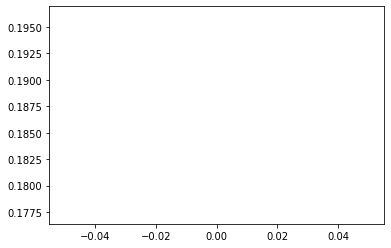

In [14]:
print(losslist)
plt.plot(losslist)

Starting Training of GRU model


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 40/500 Done, Total Loss: 0.004097338083998433   Time Elapsed: 7.320529000000533 seconds
Epoch 80/500 Done, Total Loss: 0.0037441652190561094   Time Elapsed: 6.919711000000461 seconds
Epoch 120/500 Done, Total Loss: 0.005133579276309955   Time Elapsed: 9.878357999999935 seconds
Epoch 160/500 Done, Total Loss: 0.003993770126105537   Time Elapsed: 6.33213699999942 seconds
Epoch 200/500 Done, Total Loss: 0.003922862423923872   Time Elapsed: 7.5237900000010995 seconds
Epoch 240/500 Done, Total Loss: 0.003261406180663182   Time Elapsed: 8.338477000001149 seconds
Epoch 280/500 Done, Total Loss: 0.00375315565098491   Time Elapsed: 4.257243000000017 seconds
Epoch 320/500 Done, Total Loss: 0.0024796666703113014   Time Elapsed: 8.444962999999916 seconds
Epoch 360/500 Done, Total Loss: 0.002968502955304252   Time Elapsed: 7.275397999999768 seconds
Epoch 400/500 Done, Total Loss: 0.002702725483917646   Time Elapsed: 3.6951500000013766 seconds
Epoch 440/500 Done, Total Loss: 0.0041451899201742

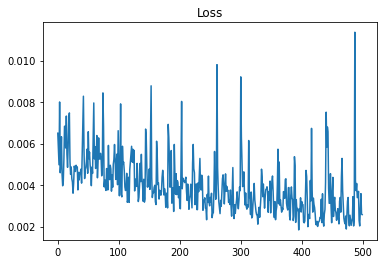

Vs Training Set
Evaluation Time: 0.20899000000099477
sMAPE: 0.43415500258347134%
1.0041623
Vs Test Set
Evaluation Time: 0.06400399999984074
sMAPE: 10.06005890538224%

 vs training data= 2022 / 2022  vs test data= 584 / 674 86 % at max difference 0.2
Vs Training Set
Evaluation Time: 0.1445480000002135
sMAPE: 0.43415500258347134%
1.0041623
Vs Test Set
Evaluation Time: 0.061635000000023865
sMAPE: 10.06005890538224%

 vs training data= 2022 / 2022  vs test data= 601 / 674 89 % at max difference 0.3
Vs Training Set
Evaluation Time: 0.11696699999993143
sMAPE: 0.43415500258347134%
1.0041623
Vs Test Set
Evaluation Time: 0.04388699999981327
sMAPE: 10.06005890538224%

 vs training data= 2022 / 2022  vs test data= 613 / 674 90 % at max difference 0.4
Vs Training Set
Evaluation Time: 0.16941199999928358
sMAPE: 0.43415500258347134%
1.0041623
Vs Test Set
Evaluation Time: 0.04598299999997835
sMAPE: 10.06005890538224%

 vs training data= 2022 / 2022  vs test data= 623 / 674 92 % at max difference 0.5


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:184: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:199: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [13]:
gru_model2= train_existing_model(gru_model,train_loader, lr , hidden_dim=128, EPOCHS=500, model_type="GRU")

train2 ,test2=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,maxdifference=.2)
train3 ,test3=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,maxdifference=.3)
train4 ,test4=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,maxdifference=.4)
train5 ,test5=evaluatefull_cutoff(gru_model2, train_x, train_y, test_x, test_y,maxdifference=.5)

In [54]:
def evaluate_episode(model, data,  maxdifference=0.2, verbose=False):

   
    model.eval()
    inp = torch.from_numpy(np.array(data)) # should be 5x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #print("model output",out)
    return out

In [10]:
import time
from datetime import date

today = date.today()    
todaydate = today.strftime("%m_%d_%Y")
print(todaydate)
torch.save(gru_model,"currentmodel_uneven0_"+todaydate+".pt")
torch.save(gru_model2,"currentmodel_uneven2_"+todaydate+".pt")
torch.save(gru_model3,"currentmodel_uneven3_"+todaydate+".pt")
torch.save(gru_model4,"currentmodel_uneven4_"+todaydate+".pt")
torch.save(gru_model5,"currentmodel_uneven5_"+todaydate+".pt")
torch.save(gru_model6,"currentmodel_uneven6_"+todaydate+".pt")

print("model saved")

10_14_2021
model saved


In [17]:


import time
from datetime import date

today = date.today()    
todaydate = today.strftime("%m_%d_%Y")
print(todaydate)
torch.save(gru_model,"currentmodel_"+todaydate+".pt")
#torch.save(gru_model,"currentmodel_10_13_2021.pt")

#currentmodel_10_13_2021
print("model saved")

10_14_2021
model saved


/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test model on new data

In [55]:
gru_model3=torch.load('currentmodel_10_14_2021.pt')
gru_model3.eval()
print("loaded")

loaded


In [62]:
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=-1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.05)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.3)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.5)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.6)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.8)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.9)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.95)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.99)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=29)

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:184: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


 vs training data= 2100 / 8307  vs test data= 669 / 2769 24.16 % at cutoff -1
TEST SET: Fails for button not pressed: 2100 Fails for button pressed: 0 Total Fails: 2100

 vs training data= 8202 / 8307  vs test data= 2437 / 2769 88.01 % at cutoff 0.05
TEST SET: Fails for button not pressed: 308 Fails for button pressed: 24 Total Fails: 332

 vs training data= 8297 / 8307  vs test data= 2578 / 2769 93.1 % at cutoff 0.1
TEST SET: Fails for button not pressed: 157 Fails for button pressed: 34 Total Fails: 191

 vs training data= 8306 / 8307  vs test data= 2624 / 2769 94.76 % at cutoff 0.2
TEST SET: Fails for button not pressed: 101 Fails for button pressed: 44 Total Fails: 145

 vs training data= 8307 / 8307  vs test data= 2641 / 2769 95.38 % at cutoff 0.3
TEST SET: Fails for button not pressed: 69 Fails for button pressed: 59 Total Fails: 128

 vs training data= 8307 / 8307  vs test data= 2657 / 2769 95.96 % at cutoff 0.4
TEST SET: Fails for button not pressed: 46 Fails for button pressed

In [ ]:
"""

train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=-1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.05)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.1)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.2)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.3)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.5)
train2 ,test2=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.6)
train3 ,test3=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.7)
train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.8)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.9)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.95)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.99)
train5 ,test5=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=29)

"""

train4 ,test4=evaluatefull_cutoff(gru_model3, train_x, train_y, test_x, test_y,cutoff=.4)

1.0 -0.059317607 X
1.0 0.013743196 X
1.0 0.3206702 X
1.0 0.20397753 X
1.0 0.34968364 X
1.0 0.39109656 X
0.0 0.83055 X
1.0 0.32075873 X
1.0 0.2951811 X
1.0 0.1746245 X
0.0 0.5169956 X
1.0 0.21918789 X
1.0 0.279225 X
1.0 0.12876199 X
1.0 0.2822536 X
1.0 0.13768189 X
1.0 -0.014581513 X
1.0 0.28268158 X
1.0 0.005234275 X
1.0 0.20203838 X
0.0 0.42393252 X
0.0 0.75349927 X
0.0 0.86861104 X
1.0 0.04554108 X
1.0 0.08155362 X
0.0 0.9866693 X
1.0 0.27556306 X
0.0 0.51979023 X
1.0 0.13671936 X
0.0 0.60909337 X
1.0 0.18158866 X
1.0 0.19021578 X
1.0 0.12952061 X
1.0 -0.12519841 X
0.0 1.0506319 X
0.0 0.75267094 X
0.0 0.53744304 X
0.0 0.9962996 X
0.0 0.4261656 X
0.0 0.7965529 X
1.0 0.012111668 X
1.0 -0.00026081875 X
1.0 0.2987233 X
1.0 -0.006659236 X
1.0 -0.033727895 X
1.0 0.11147998 X
0.0 0.5185608 X
0.0 0.5499466 X
0.0 0.4061566 X
0.0 0.7020533 X
0.0 0.6763849 X
0.0 0.50154936 X
1.0 -0.02633546 X
1.0 0.17225792 X
1.0 0.09286335 X
1.0 0.06563631 X
0.0 0.85130143 X
1.0 0.2113518 X
1.0 0.20025522 X
1.

/home/scott/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:184: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
randomindex=random.randint(0,225)
print("index=",randomindex)

exampledata=np.expand_dims(test_x[207, 0:5, 0:10], axis=0)

print(exampledata.shape)
prediction=evaluate_episode(gru_model3, exampledata)

print("prediction",float(prediction), "  actual",test_y[randomindex])

index= 44
(1, 5, 10)
prediction 0.2498023509979248   actual [0.]


## simlulate a buffer of 10 timesteps entering the classifier over a 1 episode, and classifying them. Filling empty data with zeroes or ones

In [12]:
outputlist=[]

randomindex=random.randint(0,225)
print("index=",randomindex)
exampledata=np.expand_dims(test_x[randomindex, 0:5, 0:10], axis=0)


#print(temparray.shape)
#temparray=np.expand_dims(temparray, axis=1)

#print(temparray.shape)
#print(temparray)

#temparray2=test_x[randomindex, 0:5, 0]
#temparray2=np.expand_dims(temparray2, axis=1)

for i in range(9):
    if i!=10:
        temparray=np.ones((5,1)) #test_x[randomindex, 0:5, 0]   #zeroes or "ones" here seems to work equally well. 
    
    for j in range(8-i):
        #temparray2=test_x[randomindex, 0:5, 0]
        #temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,np.ones((5,1)),axis=1)       #zeroes or "ones" here seems to work equally well. 
        #temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)   
    
    for j in range(i+1):

        temparray2=test_x[randomindex, 0:5, j]
        temparray2=np.expand_dims(temparray2, axis=1)
        temparray=np.append(temparray,temparray2,axis=1)
        #temparray=np.append(np.zeros((5,1)),temparray,axis=1)

    
    #print(temparray)
    temparray=np.expand_dims(temparray, axis=0)
    outputpartial=evaluate_episode(gru_model3, temparray)
    
    
    outputlist.append(float(outputpartial))

print("final partial data")
print(temparray)   
print("")
print("full data")
print(exampledata)




#print("prediction from",x," timesteps",float(outputpartial),"actual",test_y[randomindex])
print("predictions:",outputlist)


#print("full data")
#print(exampledata)
print("")
#print("evaluating all 10 timesteps")

outputfull=evaluate_episode(gru_model3, exampledata)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",test_y[randomindex])


index= 188
final partial data
[[[1.         0.64779416 0.68590197 0.69517914 0.69903447 0.71459429
   0.71267351 0.71409191 0.71673093 0.72399386]
  [1.         0.52154944 0.52310862 0.53282553 0.52718083 0.53709991
   0.52978522 0.54277099 0.53688102 0.54443726]
  [1.         0.8726286  0.96482141 0.95083008 0.94447182 0.93691809
   0.95239155 0.9493714  0.95276295 0.95638539]
  [1.         0.50752062 0.50852903 0.49810241 0.50102952 0.4947311
   0.50046923 0.49000781 0.49422322 0.48543027]
  [1.         0.62007232 0.67079484 0.67376652 0.67304434 0.68618886
   0.68665851 0.69233506 0.69529406 0.70288601]]]

full data
[[[0.64779416 0.68590197 0.69517914 0.69903447 0.71459429 0.71267351
   0.71409191 0.71673093 0.72399386 0.7219988 ]
  [0.52154944 0.52310862 0.53282553 0.52718083 0.53709991 0.52978522
   0.54277099 0.53688102 0.54443726 0.53999553]
  [0.8726286  0.96482141 0.95083008 0.94447182 0.93691809 0.95239155
   0.9493714  0.95276295 0.95638539 0.94038139]
  [0.50752062 0.508529

## classifying progression of 10 actual forces and torques in a sucessful sequence longer than 10

In [19]:
originaldata=pd.read_csv('forcetorquebuttonresults_renormalized_10_06_2021_newrange.csv')#.head()
print(originaldata.shape)
headers=[]
lookback=30 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    headers.append("header"+label)
print(headers)

(7200, 30)
['header0', 'header1', 'header2', 'header3', 'header4', 'header5', 'header6', 'header7', 'header8', 'header9', 'header10', 'header11', 'header12', 'header13', 'header14', 'header15', 'header16', 'header17', 'header18', 'header19', 'header20', 'header21', 'header22', 'header23', 'header24', 'header25', 'header26', 'header27', 'header28', 'header29']


In [40]:
originaldata.iloc[4039:4044]

,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4039,0.376258,0.371196,0.374959,0.381994,0.378138,0.375871,0.375117,0.372087,0.372973,0.372174,...,0.313334,0.297908,0.300916,0.295691,0.304691,0.297850,0.298842,0.298431,0.323285,NaN
4040,0.932410,0.930584,0.929513,0.928026,0.928930,0.929664,0.929868,0.929412,0.930946,0.929839,...,0.887794,0.927183,0.923606,0.929387,0.921559,0.932170,0.925471,0.922702,0.851257,NaN
4041,0.639841,0.640750,0.639536,0.639553,0.639504,0.639946,0.638688,0.639430,0.639626,0.639553,...,0.689476,0.707595,0.706714,0.707579,0.702587,0.708988,0.708745,0.709223,0.693128,NaN
4042,0.546462,0.547252,0.546158,0.546371,0.546241,0.545721,0.546231,0.545329,0.545053,0.544635,...,0.516504,0.504406,0.494093,0.490169,0.484280,0.477127,0.479447,0.476531,0.484857,NaN
4043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN


In [19]:

#print(originaldata[headers[0:30]].iloc[4039:4044])
#print(originaldata[headers[0:30]].iloc[4039:4044].to_numpy()
classifytest=originaldata[headers[19:29]].iloc[4038:4043].to_numpy()
labelstest=originaldata[headers[19:29]].iloc[4043].to_numpy()
print(classifytest)
classifytest=np.expand_dims(classifytest, axis=0)
print(classifytest.shape)
print(labelstest)

outputfull=evaluate_episode(gru_model3, classifytest)

print("")

#print("evaluating 1st timestep repeated 10 times")


#print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
print("prediction from 10 timesteps",float(outputfull),"actual",labelstest[9])

[[0.54251199 0.52489482 0.52926319 0.5065195  0.49991385 0.49536954
  0.48716645 0.48923134 0.48428939 0.51027604]
 [0.37858933 0.31333356 0.29790778 0.30091579 0.29569087 0.30469148
  0.29785046 0.29884238 0.29843066 0.32328525]
 [0.93041265 0.88779361 0.92718331 0.92360628 0.92938742 0.92155946
  0.9321705  0.92547146 0.92270207 0.85125721]
 [0.63809043 0.68947554 0.70759451 0.70671384 0.70757924 0.7025874
  0.70898769 0.70874526 0.70922296 0.69312779]
 [0.54499817 0.51650444 0.50440577 0.49409301 0.49016859 0.48428045
  0.47712741 0.4794472  0.4765313  0.48485743]]
(1, 5, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

prediction from 10 timesteps 1.0079834461212158 actual 1.0


In [21]:

okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4296:4301].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4301].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : -0.00722537562251091 actual 0.0 OK
prediction from timestep 1 - 11  : -0.002346884459257126 actual 0.0 OK
prediction from timestep 2 - 12  : 0.7899943590164185 actual 0.0 X
prediction from timestep 3 - 13  : -0.029703717678785324 actual 0.0 OK
prediction from timestep 4 - 14  : 0.012947771698236465 actual 0.0 OK
prediction from timestep 5 - 15  : -0.028719600290060043 actual 0.0 OK
prediction from timestep 6 - 16  : -0.07998156547546387 actual 0.0 OK
prediction from timestep 7 - 17  : -0.02647894248366356 actual 0.0 OK
prediction from timestep 8 - 18  : -0.02107241377234459 actual 0.0 OK
prediction from timestep 9 - 19  : -0.0006447099149227142 actual 0.0 OK
prediction from timestep 10 - 20  : 0.015007872134447098 actual 0.0 OK
prediction from timestep 11 - 21  : -0.04580749198794365 actual 0.0 OK
prediction from timestep 12 - 22  : -0.04300672933459282 actual 0.0 OK
prediction from timestep 13 - 23  : 0.0236160047352314 actual 0.0 OK
prediction from 

In [38]:
originaldata.iloc[4890:4896]

,header0,header1,header2,header3,header4,header5,header6,header7,header8,header9,...,header20,header21,header22,header23,header24,header25,header26,header27,header28,header29
4890,0.519653,0.629009,0.666283,0.757858,0.748447,0.748698,0.751999,0.743304,0.741959,0.748569,...,0.785070,0.768524,0.756693,0.763045,0.771942,0.774374,NaN,NaN,NaN,NaN
4891,0.372140,0.333817,0.319136,0.330614,0.324397,0.318553,0.308498,0.310825,0.340429,0.380643,...,0.510981,0.545773,0.534438,0.555681,0.578675,0.561716,NaN,NaN,NaN,NaN
4892,0.932075,0.880805,0.871212,0.782250,0.917737,0.913229,0.930457,0.932578,0.922336,0.936276,...,0.951116,0.928739,0.959949,0.949016,0.937812,0.899633,NaN,NaN,NaN,NaN
4893,0.641091,0.669016,0.684142,0.675920,0.699291,0.686433,0.692765,0.690845,0.670727,0.643720,...,0.498684,0.474195,0.481877,0.466092,0.447252,0.446521,NaN,NaN,NaN,NaN
4894,0.550714,0.634439,0.686677,0.743846,0.772609,0.768783,0.769648,0.771199,0.775574,0.782100,...,0.835276,0.823710,0.817117,0.822949,0.825044,0.824857,NaN,NaN,NaN,NaN
4895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


In [22]:
okcounter=0
for i in range(20):
    classifytest=originaldata[headers[i:10+i]].iloc[4890:4895].to_numpy()
    labelstest=originaldata[headers[i:10+i]].iloc[4895].to_numpy()
    #print(classifytest)
    classifytest=np.expand_dims(classifytest, axis=0)
    #print(classifytest.shape)
    #print(labelstest)

    outputfull=evaluate_episode(gru_model3, classifytest)

    #print("")

    #print("evaluating 1st timestep repeated 10 times")


    #print("prediction from 1 timestep",float(outputpartial),"actual",test_y[randomindex])
    
    if abs(float(outputfull)-labelstest[9])>0.3:
        result="X"
    else:
        result="OK"
        okcounter+=1
    print("prediction from timestep",i,"-",i+10," :",float(outputfull),"actual",labelstest[9], result)
print("okcounter",okcounter)

prediction from timestep 0 - 10  : 0.004739541560411453 actual 0.0 OK
prediction from timestep 1 - 11  : 0.001866895705461502 actual 0.0 OK
prediction from timestep 2 - 12  : 0.001510579138994217 actual 0.0 OK
prediction from timestep 3 - 13  : 0.03851709142327309 actual 0.0 OK
prediction from timestep 4 - 14  : 0.003079596906900406 actual 0.0 OK
prediction from timestep 5 - 15  : 0.02709074690937996 actual 0.0 OK
prediction from timestep 6 - 16  : 0.022011790424585342 actual 0.0 OK
prediction from timestep 7 - 17  : 0.004578161984682083 actual 0.0 OK
prediction from timestep 8 - 18  : 0.022756803780794144 actual 0.0 OK
prediction from timestep 9 - 19  : -0.05372391268610954 actual 0.0 OK
prediction from timestep 10 - 20  : 0.32199326157569885 actual 0.0 X
prediction from timestep 11 - 21  : 0.01846003159880638 actual 0.0 OK
prediction from timestep 12 - 22  : -0.11743395030498505 actual 0.0 OK
prediction from timestep 13 - 23  : 0.026684287935495377 actual 0.0 OK
prediction from times